In [1]:
import numpy as np
from scipy.linalg import norm, eigh
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import eigsh as speigsh
from scipy.sparse.linalg import norm as spnorm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Utility & Logging
import os
import time
import sys
import logbook
from logbook import Logger, StreamHandler, FileHandler, DEBUG, INFO, WARNING, ERROR, NOTSET
from tqdm.notebook import tqdm

In [2]:
np.random.seed(42)

DATA_PATH = 'data/ex3'
MEDIA_PATH = 'media/ex3'
LOG_PATH = 'log'
ANIM_BACKEND = 'ffmpeg'
os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(MEDIA_PATH, exist_ok=True)
os.makedirs(LOG_PATH, exist_ok=True)

LOAD_CACHED_FILES_IF_AVAILABLE = True

log = Logger('Set 3 Logger')
fh = FileHandler(f'{LOG_PATH}/ex3_1_1.log', mode='w', level=DEBUG, bubble=True)
fh.push_application()

Function to generate five-point stencil to discretize Laplacian

In [163]:
def fd_laplacian_matrix_inner(nx, ny, Lx, Ly, sparse=False, radius=None):
    '''
    Creates a five-point stencil finite difference matrix M to approximate the Laplacian operator in eigenvalue problem.
    Excludes the boundary points as they are stationary.

    Args:
        nx (int): Number of grid points in the x direction.
        ny (int): Number of grid points in the y direction.

    Returns:
        np.ndarray: The five-point stencil finite difference matrix M for the inner points.
    '''
    log.info(f'Creating Laplacian approximation matrix for {nx}x{ny} grid with Lx={Lx}, Ly={Ly} with sparse mode = {sparse}.')
    dx, dy = Lx / (nx - 1), Ly / (ny - 1)
    N = (nx - 2) * (ny - 2)  # Excluding boundary points
    if sparse:
        M = lil_matrix((N, N))
    else:
        M = np.zeros((N, N))

    for i in range(1, nx - 1):
        for j in range(1, ny - 1):
            index = (i - 1) * (ny - 2) + (j - 1)  # accounting for excluded boundary points

            M[index, index] = -2 / dx**2 - 2 / dy**2

            if i > 1:
                M[index, index - (ny - 2)] = 1 / dx**2
            if i < nx - 2:
                M[index, index + (ny - 2)] = 1 / dx**2

            if j > 1:
                M[index, index - 1] = 1 / dy**2
            if j < ny - 2:
                M[index, index + 1] = 1 / dy**2

    if radius is not None:
        r = radius * min(nx, ny)
        log.debug(f'Applying radius {r} to the Laplacian matrix.')
        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                index = (i - 1) * (ny - 2) + (j - 1)
                x, y = i * dx, j * dy
                if np.sqrt(x**2 + y**2) < r:
                    M[index, :] = 0
                    M[index, index] = 1

    if sparse:
        M = M.tocsr()
        log.info(f'Matrix M is {size_in_bytes(M)} bytes large.')
        return M
    else:
        log.info(f'Matrix M is {size_in_bytes(M)} bytes large.')
        return M
    
def size_in_bytes(M):
    '''
    Returns the size of the matrix M in bytes.
    '''
    if isinstance(M, np.ndarray):
        return M.nbytes
    elif hasattr(M, 'data'):
        return M.data.nbytes + M.indptr.nbytes + M.indices.nbytes
    else:
        raise NotImplementedError('Unknown matrix type')

# def add_boundary_to_laplacian(M):
#     '''
#     Adds the edges back to the finite difference matrix M.
#     '''
#     log.debug(f'Adding boundary to matrix M.')
#     Nx, Ny = M.shape
#     if isinstance(M, np.ndarray):
#         M_full = np.zeros((Nx + 2, Ny + 2))
#         M_full[1:-1, 1:-1] = M
#         return M_full
#     elif hasattr(M, 'data'):
#         M_full = lil_matrix((Nx + 2, Ny + 2))
#         M_full[1:-1, 1:-1] = M.todense()
#         return M_full.tocsr()
#     else:
#         raise NotImplementedError('Unknown matrix type')
    
def add_boundary_to_eigvec(eigvec, nx, ny):
    '''
    Adds the edges back to the eigenvector eigvec.
    '''
    log.debug('Adding boundary to eigenvector.')
    Nx, Ny = nx + 2, ny + 2
    eigvec_full = np.zeros((Nx, Ny))
    eigvec_full[1:-1, 1:-1] = eigvec.reshape(nx, ny)
    return eigvec_full

def solve_eigenvalue_problem(Nx, Ny, Lx, Ly, radius=None, sort_order='ascending', sparse=False, sparse_k=None, sparse_which=None):
    '''
    Solves the eigenvalue problem Mv = Kv for the matrix M, here a finite difference approximation of the Laplacian operator.

    Args:
        Nx (int): Number of discretization points in x.
        Ny (int): Number of discretization points in y.
        Lx (float): Length of the object in x.
        Ly (float): Length of the object in y.
        sort_order (str): The order in which to sort returned values, either `ascending` or `descending`.
        sparse (bool): Whether to use sparse mode.
        sparse_k (int): The number of eigenvalues to compute (in sparse mode only).
        sparse_which (str): Which eigenvalues to compute (in sparse mode only).

    Returns:
        np.ndarray: The finite difference matrix M.
        np.ndarray: The eigenvalues K.
        np.ndarray: The eigenvectors v.
        np.ndarray: The eigenfrequencies f.
    '''
    nx, ny = Nx-2, Ny-2
    N = nx * ny
    dx, dy = Lx / (nx - 1), Ly / (ny - 1)

    M = fd_laplacian_matrix_inner(Nx, Ny, Lx, Ly, sparse=sparse, radius=radius)
    log.info(f'Solving eigenvector problem Mv = Kv for the finite difference matrix M of size ({M.shape[0]},{M.shape[1]}).')

    if sparse:
        if sparse_k is None:
            log.error('sparse_k should be provided if sparse is True. Using N-2 as default, but this may be slow.')
            sparse_k = N-2
        if sparse_which is None:
            log.error('sparse_which should be provided if sparse is True. Using "BA" as default, but this may not be the intended result.')
            sparse_which = 'BE'
        eigvals, eigvecs = speigsh(M, k=sparse_k, which=sparse_which)
    else:
        eigvals, eigvecs = eigh(M)

    log.info(f'Sorting eigenvalues and vectors in {sort_order} order.')
    # Sort the eigenvalues and eigenvectors
    if sort_order == 'ascending':
        sort_indices = np.argsort(eigvals)
    elif sort_order == 'descending':
        sort_indices = np.argsort(-eigvals)
    else:
        raise ValueError('sort_order must be "ascending" or "descending"')
    
    eigvals, eigvecs = eigvals[sort_indices], eigvecs[:, sort_indices]
    eigfreqs = np.sqrt(-eigvals)
    
    return M, eigvals, eigvecs, eigfreqs

def vis_eigvecs(eigvecs, eigvals, eigfreqs, Nx, Ny, Lx, Ly, plot_shape=(1, 3), select='first'):
    plx, ply = plot_shape
    plratio = Nx/Ny
    nx, ny = Nx-2, Ny-2
    fig, axs = plt.subplots(plx, ply, figsize=(10*plratio, 5), constrained_layout=True)
    fig.suptitle(f'Eigenmodes for an object of size $L_x={Lx}, L_y={Ly}$ with $c=1$')
    images = []
    
    if select == 'first':
        vmin = np.min(eigvecs[:, :len(axs.flatten())])
        vmax = np.max(eigvecs[:, :len(axs.flatten())])
    elif select == 'last':
        vmin = np.min(eigvecs[:, -len(axs.flatten()):])
        vmax = np.max(eigvecs[:, -len(axs.flatten()):])
    else:
        raise ValueError('select must be "first" or "last')
    norm = Normalize(vmin=vmin, vmax=vmax)

    for i, ax in enumerate(axs.flatten()):
        if select == 'first':
            eigvec, eigval, eigfreq = eigvecs[:, i], eigvals[i], eigfreqs[i]
        elif select == 'last':
            eigval, eigvec, eigfreq = eigvals[-(i+1)], eigvecs[:, -(i+1)], eigfreqs[-(i+1)]
        else:
            raise ValueError('select must be "first" or "last"')
        eigvec = np.rot90(add_boundary_to_eigvec(eigvec, nx, ny).reshape(Nx, Ny))
        im = ax.imshow(eigvec, origin='lower', norm=norm)
        images.append(im)
        ax.set_title(f'$f_{i}={eigfreq:.2f} Hz$')
        ax.axis('off')

    fig.colorbar(images[0], ax=axs.ravel().tolist(), orientation='horizontal', label='Amplitude', norm=norm, shrink=0.75)

    return fig

Comparison of memory requirements and matrix types

In [164]:
nx, ny = 5, 5
Lx, Ly = 1, 1

M_inner = fd_laplacian_matrix_inner(nx, ny, Lx, Ly, sparse=False)
print(M_inner)
print(f'Size in memory (dense): {size_in_bytes(M_inner)} bytes')

Ms_inner = fd_laplacian_matrix_inner(nx, ny, Lx, Ly, sparse=True)
# print(Ms_inner)
print(f'Size in memory (sparse): {size_in_bytes(Ms_inner)} bytes')

# Test circle mask
# M_inner_circle = fd_laplacian_matrix_inner(nx, ny, Lx, Ly, sparse=False, radius=2)
# print(M_inner_circle)

[[-64.  16.   0.  16.   0.   0.   0.   0.   0.]
 [ 16. -64.  16.   0.  16.   0.   0.   0.   0.]
 [  0.  16. -64.   0.   0.  16.   0.   0.   0.]
 [ 16.   0.   0. -64.  16.   0.  16.   0.   0.]
 [  0.  16.   0.  16. -64.  16.   0.  16.   0.]
 [  0.   0.  16.   0.  16. -64.   0.   0.  16.]
 [  0.   0.   0.  16.   0.   0. -64.  16.   0.]
 [  0.   0.   0.   0.  16.   0.  16. -64.  16.]
 [  0.   0.   0.   0.   0.  16.   0.  16. -64.]]
Size in memory (dense): 648 bytes
Size in memory (sparse): 436 bytes


Visualizing eigenmodes for dense and sparse matrix and square drum of size $L_x = L_y = 1$.

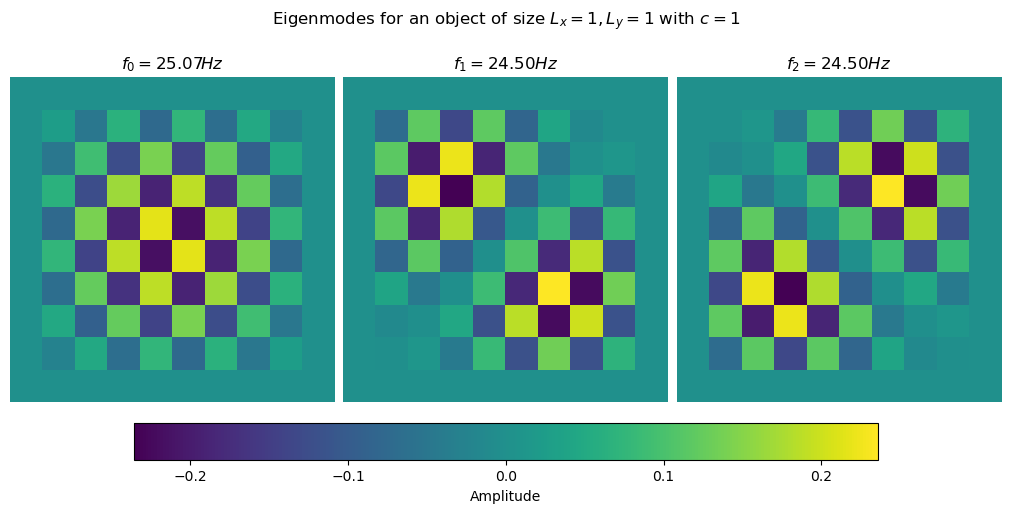

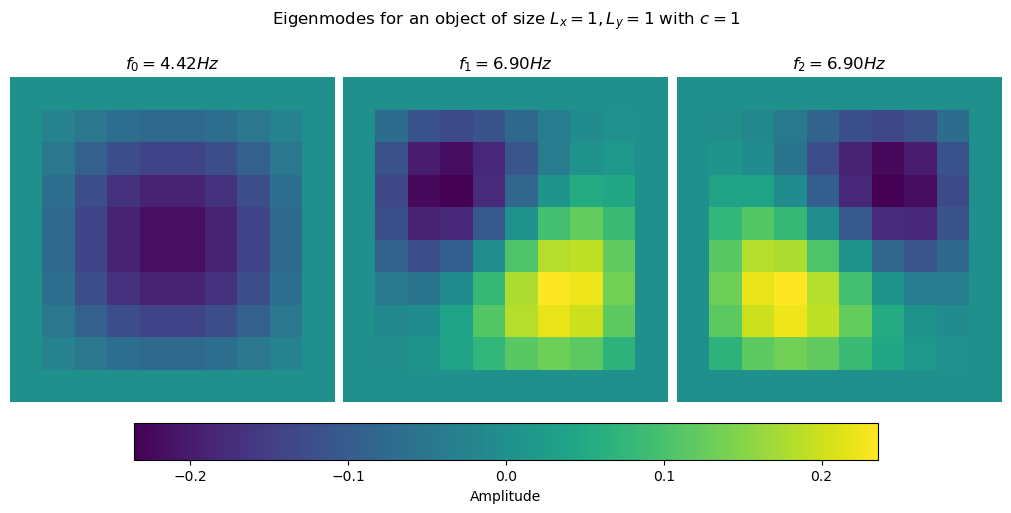

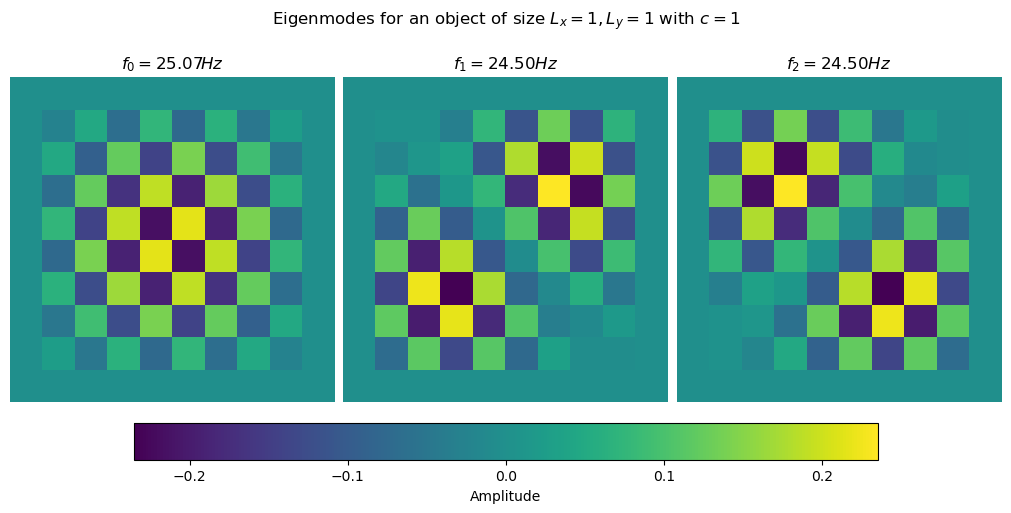

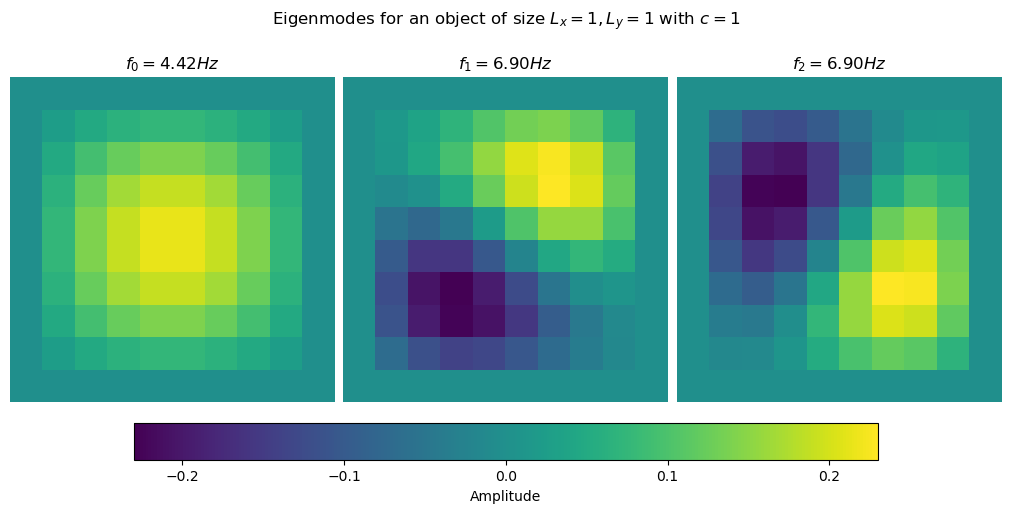

In [165]:
# Dense code
Nx, Ny = 10, 10
nx, ny = Nx-2, Ny-2
N = nx * ny
Lx, Ly = 1, 1

M, eigvals, eigvecs, eigfreqs = solve_eigenvalue_problem(Nx, Ny, Lx, Ly, sort_order='ascending')

fig = vis_eigvecs(eigvecs, eigvals, eigfreqs, Nx, Ny, Lx, Ly, plot_shape=(1, 3), select='first')
fig.savefig(f'{MEDIA_PATH}/eigvecs_lowest_dense_{Nx}x{Ny}_L={Lx}x{Ly}.png')

fig2 = vis_eigvecs(eigvecs, eigvals, eigfreqs, Nx, Ny, Lx, Ly, plot_shape=(1, 3), select='last')
fig2.savefig(f'{MEDIA_PATH}/eigvecs_highest_dense_{Nx}x{Ny}_L={Lx}x{Ly}.png')

# Sparse code
sparse_which = 'BE'
sparse_k = 6

M, eigvals, eigvecs, eigfreqs = solve_eigenvalue_problem(Nx, Ny, Lx, Ly, sort_order='ascending', sparse=True, sparse_k=sparse_k, sparse_which=sparse_which)

fig = vis_eigvecs(eigvecs, eigvals, eigfreqs, Nx, Ny, Lx, Ly, plot_shape=(1, 3), select='first')
fig.savefig(f'{MEDIA_PATH}/eigvecs_lowest_sparse_{Nx}x{Ny}_L={Lx}x{Ly}_k={sparse_k}_which={sparse_which}.png')

fig2 = vis_eigvecs(eigvecs, eigvals, eigfreqs, Nx, Ny, Lx, Ly, plot_shape=(1, 3), select='last')
fig2.savefig(f'{MEDIA_PATH}/eigvecs_highest_sparse_{Nx}x{Ny}_L={Lx}x{Ly}_k={sparse_k}_which={sparse_which}.png')

Visualizing eigenmodes of a rectangular drum of size $L_x = 1$ and $L_y = 2$.

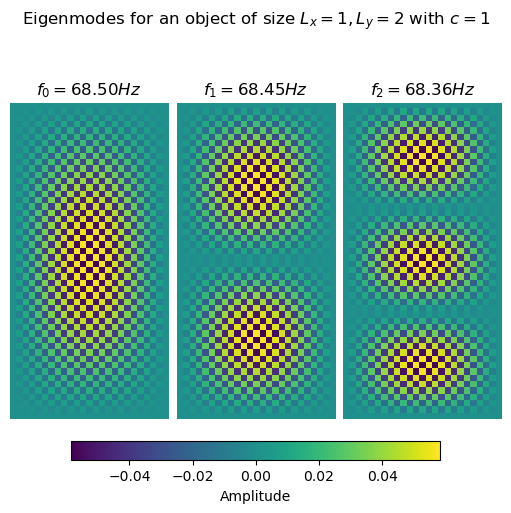

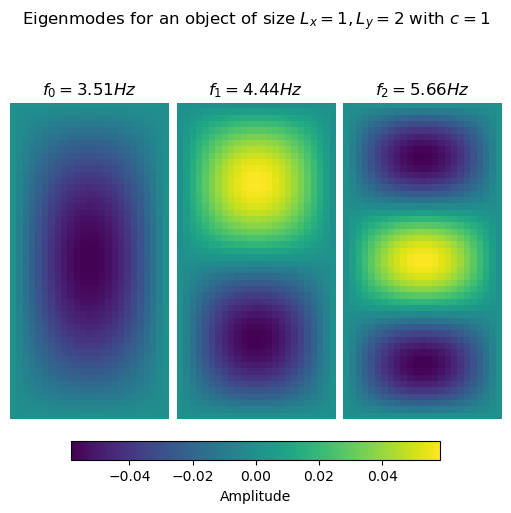

In [166]:
Nx, Ny = 25, 50
nx, ny = Nx-2, Ny-2
N = nx * ny
Lx, Ly = 1, 2
sparse_k = 6
sparse_which = 'BE'

M, eigvals, eigvecs, eigfreqs = solve_eigenvalue_problem(Nx, Ny, Lx, Ly, sort_order='ascending', sparse=True, sparse_k=sparse_k, sparse_which=sparse_which)

fig = vis_eigvecs(eigvecs, eigvals, eigfreqs, Nx, Ny, Lx, Ly, plot_shape=(1, 3), select='first')
fig.savefig(f'{MEDIA_PATH}/eigvecs_lowest_sparse_{Nx}x{Ny}_L={Lx}x{Ly}.png')

fig2 = vis_eigvecs(eigvecs, eigvals, eigfreqs, Nx, Ny, Lx, Ly, plot_shape=(1, 3), select='last')
fig2.savefig(f'{MEDIA_PATH}/eigvecs_highest_sparse_{Nx}x{Ny}_L={Lx}x{Ly}.png')

In [170]:
# Nx, Ny = 25, 25
# nx, ny = Nx-2, Ny-2
# N = nx * ny
# Lx, Ly = 1, 1
# radius = 0.5
# sparse_k = 6
# sparse_which = 'BE'

# M, eigvals, eigvecs, eigfreqs = solve_eigenvalue_problem(Nx, Ny, Lx, Ly, radius=radius, sort_order='ascending', sparse=True, sparse_k=sparse_k, sparse_which=sparse_which)

# fig = vis_eigvecs(eigvecs, eigvals, eigfreqs, Nx, Ny, Lx, Ly, plot_shape=(1, 3), select='first')
# fig.savefig(f'{MEDIA_PATH}/eigvecs_lowest_sparse_{Nx}x{Ny}_L={Lx}x{Ly}.png')

# fig2 = vis_eigvecs(eigvecs, eigvals, eigfreqs, Nx, Ny, Lx, Ly, plot_shape=(1, 3), select='last')
# fig2.savefig(f'{MEDIA_PATH}/eigvecs_highest_sparse_{Nx}x{Ny}_L={Lx}x{Ly}.png')